In [1]:
%matplotlib inline

import sys
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
torch.set_default_tensor_type('torch.cuda.FloatTensor') 

from torchvision.models import vgg16
from torch.nn import Module, Sequential, MSELoss, L1Loss
from torch.autograd import Variable
import torch.nn.functional as F


# выражение из статьи по style-transfer
def caffeActivation(x):
    x = 255 * x
    x1 = x[:,2:,:,:] - 103.939
    x2 = x[:,1:2,:,:] - 116.779
    x3 = x[:,:1,:,:] - 123.68

    return torch.cat([x1,x2,x3], 1)


def torchFormat(x):
    reshaped = np.moveaxis(np.expand_dims(x, 0), -1,1)
    return Variable(torch.tensor(reshaped, dtype=torch.float), requires_grad=False)


def plotFormat(x):
    return np.moveaxis(x, 1, -1)[0]


def openImage(file, size):
    return np.asarray(Image.open(file).resize(resizeSize,Image.LANCZOS))/255.

In [2]:
def plotImages(columns,*images, **kwargs):
    rowHeight = kwargs.pop('rowHeight',6)
    writeValues = kwargs.pop('writeValues', False)
    titles = kwargs.pop('titles', None)
    bottomTexts = kwargs.pop('bottomTexts',None)
    
    if len(kwargs) > 0:
        warnings.warn('plotImages got some invalid arguments: ' + str([key for key in kwargs]))
    
        
    n = len(images)
    rowsDiv = divmod(n,columns)
    rows = rowsDiv[0]
    if rowsDiv[1] > 0: rows+=1
    
    fig, ax = plt.subplots(ncols=columns, nrows=rows,squeeze=False, figsize=(16,rowHeight * rows))
    
    hspace=0
    counter = Incrementer2D(columns)
    for i in range(n):
        image = images[i]
        if image.max() > 1:
            image = image/255.
        ax[counter.i,counter.j].imshow(image,cmap=cm.Greys_r if len(image.shape) == 2 else None)
        ax[counter.i,counter.j].get_xaxis().set_ticks([])
        ax[counter.i,counter.j].get_yaxis().set_ticks([])
        
        if writeValues:
            for (y,x),label in np.ndenumerate(image):
                txt = str(label)[:5] if len(str(label)) >= 5 else str(label)
                ax[counter.i,counter.j].text(x,y,txt,ha='center',va='center',color='blue')
        
        if not titles is None:
            ax[counter.i,counter.j].set_title(titles[i])
            hspace+=.06
        
        if not bottomTexts is None:
            ax[counter.i,counter.j].annotate(bottomTexts[i], (0,0), (0, -5), xycoords='axes fraction', textcoords='offset points', va='top')   
            hspace+=.06
        
        counter.increment()
            
    
    for i in range(n,columns*rows):
        ax[counter.i,counter.j].axis('off')
        counter.increment()
        
    if hspace > 0: plt.subplots_adjust(hspace=hspace/(rowHeight*rows))
    plt.show()
    

class Incrementer2D:
    def __init__(self, limitForJ, startI = 0, startJ = 0):
        self.limitForJ = limitForJ
        self.i = startI
        self.j = startJ
        
    def increment(self):
        self.j += 1
        if self.j == self.limitForJ:
            self.j = 0
            self.i += 1

A hidden image plotting function is also defined here


In [3]:
def gramMatrix(imageTensor):
    shp = list(imageTensor.size()) #shape
    pixels = shp[2] * shp[3]
    
    original = imageTensor.view(shp[0], shp[1], pixels)
    
    original = torch.sqrt(original / pixels)
    
    transposed = original.permute(0,2,1)    
    return torch.matmul(original, transposed)

def gramLoss(yPred, yTrue):
    
    trueGram = gramMatrix(yTrue)
    predGram = gramMatrix(yPred)
    
    return L1Loss()(predGram,trueGram)

In [4]:
class VGGFeatureExtractor(Module):
    def __init__(self, vggModel, layerIndices):
        super(VGGFeatureExtractor,self).__init__()
        
        self.features = vggModel.features
        
        self.layerIndices = layerIndices
        self.outputCount = len(layerIndices)
        
        for p in self.parameters():
            p.requires_grad = False
        
    def forward(self,x):
        outputs = list()
        
        for i, layer in enumerate(self.features.children()):
            x = layer(x)
            
            if i in self.layerIndices:
                outputs.append(x)
                
                if i == self.layerIndices[-1]:
                    return outputs
                    
        return outputs

In [27]:
class StyleTransferModel(object):
    
    def __init__(self,imageShape,inputActivation,baseFeatureExtractor,styleFeatureExtractor,
                 baseWeights = 1,styleWeights = 1):
        super(StyleTransferModel, self).__init__()
        
        #shape
        self.imageShape = imageShape
        self.inputActivation = inputActivation 
        self.batchShape = (1,) + imageShape
        
        self.baseModel = baseFeatureExtractor
        self.styleModel = styleFeatureExtractor
        
        self.baseOutputCount = baseFeatureExtractor.outputCount
        self.styleOutputCount = styleFeatureExtractor.outputCount
        
        self.baseWeights = [baseWeights]* self.baseOutputCount
        self.styleWeights = [styleWeights]* self.styleOutputCount
        self.allWeights = self.baseWeights + self.styleWeights
        
        self.baseLosses = [L1Loss()]*self.baseOutputCount
        self.styleLosses = [gramLoss]*self.styleOutputCount
        self.allLosses = self.baseLosses + self.styleLosses
        
        imageInputTensor = torch.rand(self.batchShape) 
        self.imageInput = Variable(imageInputTensor, requires_grad=True)

    def forward_preds(self):
        
        activatedImage = self.inputActivation(self.imageInput)
        
        basePredictions = []
        stylePredictions = []
        if self.baseOutputCount > 0:
            basePredictions = self.baseModel(activatedImage)
        if self.styleOutputCount > 0:
            stylePredictions = self.styleModel(activatedImage)

        
        outputs = basePredictions + stylePredictions
        return outputs
        

    def forward_loss(self, trainableFeatures, trueFeatures):
        
        resultLosses = []
        for trainable, true, w, lossFunction in zip(trainableFeatures, trueFeatures, 
                                                    self.allWeights, self.allLosses):
            loss = w*lossFunction(trainable,true)
            resultLosses.append(loss)

        finalLoss = resultLosses[0]
        for l in resultLosses[1:]:
            finalLoss = finalLoss + l
        return finalLoss
        
    def getInputImage(self):
        return plotFormat(self.imageInput.data.cpu().numpy())
    
    def getRawInputImage(self):
        return self.imageInput.data.cpu()
    
    def setInputImage(self,image):
        image = torchFormat(image)
        self.imageInput.data = torch.Tensor(image)
    

    def fit(self,baseImage,styleImage, epochs, optimizer, lr, patience = 30, bestLoss = sys.float_info.max, verbose=1):
        
        baseImage = self.inputActivation(torchFormat(baseImage))
        styleImage = self.inputActivation(torchFormat(styleImage))
        
        baseImageFeatures = self.baseModel.forward(baseImage) 
        styleImageFeatures = self.styleModel.forward(styleImage)
        trueFeatures = baseImageFeatures + styleImageFeatures        
        
        optimizer = optimizer([self.imageInput], lr=lr)
        
        if verbose > 0:
            print('called fit, inital img, lr:', lr)
            self.plot()
        
        patienceCounter = 0
        for e in range(epochs):
            optimizer.zero_grad()
            loss = self.forward_loss(self.forward_preds(), trueFeatures)
            loss.backward()
            optimizer.step()
            
            self.imageInput.data.clamp_(min=0,max=1)
            
            currLoss = loss.data.item()
            if currLoss < bestLoss:
                bestLoss  = currLoss
                patienceCounter = 0
            else:
                patienceCounter += 1
                if patienceCounter > patience:
                    break
            
            if verbose > 0:
                if e % 200 == 0:
                    print('loss:', loss)
                    self.plot()
                    
    def fitManyLRs(self, baseImage, styleImage, epochList, lrList):
        for epochs, lr in zip(epochList, lrList):
            self.fit(baseImage, styleImg, epochs=epochs, 
                     optimizer=torch.optim.Adam, lr=lr, verbose=0)
    
    
    #plots the trainable image
    def plot(self):
        image = self.getInputImage()
        print(image.min(),image.max())
        plotImages(1,image)

In [28]:
imgSize = 224
resizeSize = (imgSize, imgSize)
inShape = (3,imgSize,imgSize)
vgg = vgg16(pretrained=True)

baseExtractorForCat = VGGFeatureExtractor(vgg, [3,11,13,15,18,20,22,27,29])
baseExtractorForCity = VGGFeatureExtractor(vgg,[3,6,8,13,15,18,20,22,27,29])

#styleExtractor = VGGFeatureExtractor(vgg, list(range(1,31)))
styleExtractor = VGGFeatureExtractor(vgg, [3,6,8,11,13,15,18,20,22,25,27,29])

styleTransferModel = StyleTransferModel(inShape,caffeActivation, 
                                        baseExtractorForCat,styleExtractor,
                                        baseWeights = 1,styleWeights = 20)

base image:


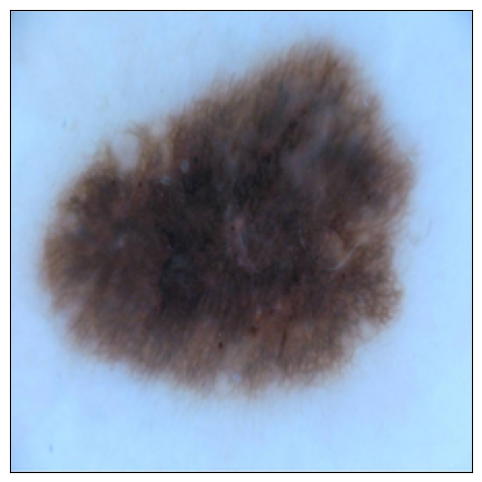

training for test2.png


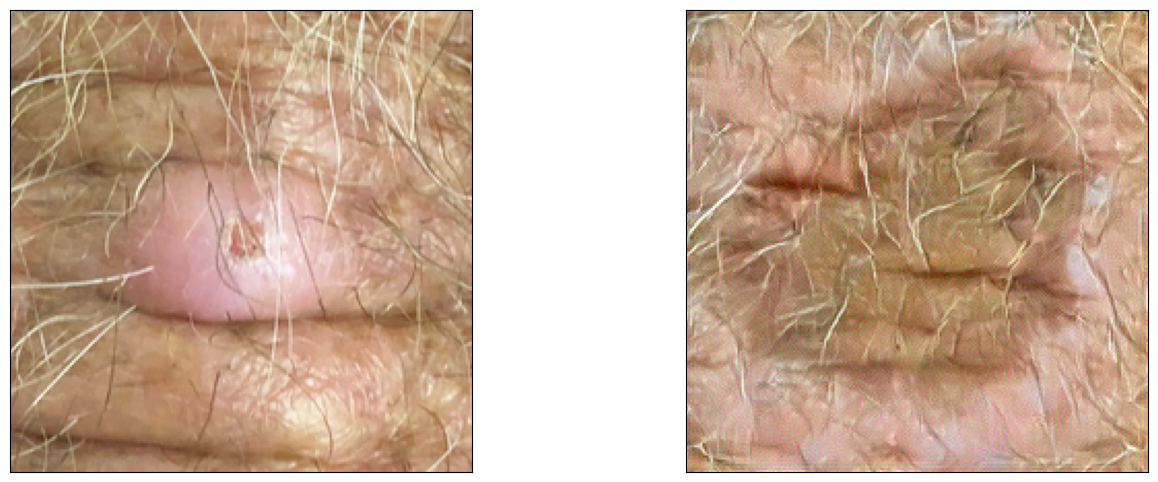

In [38]:
baseImage = openImage('test.jpg', imgSize)
print("base image:")
plotImages(1, baseImage)

styleFiles = ["test2.png"]
styleImages = [openImage(img, imgSize) for img in styleFiles]

for file, styleImg, in zip(styleFiles, styleImages):
    print('training for ' + file)
    
    styleTransferModel.setInputImage(baseImage)
    
    styleTransferModel.fitManyLRs(baseImage,styleImg,epochList=[100, 100], lrList=[0.1, 0.01])

    
    plotImages(2, styleImg, styleTransferModel.getInputImage())

In [39]:
from torchvision.transforms.functional import to_pil_image
to_pil_image(styleTransferModel.getRawInputImage().squeeze(0)).save("raw1.png")

In [40]:
import os

In [57]:
os.mkdir("IMG-3")
for x in os.listdir("IMG"):
    img = read_image(f"IMG/{x}")
    img = img[:3, :, :]
    to_pil_image(img).save(f"IMG-3/{x}")

In [63]:
from tqdm.notebook import tqdm


file = open("metadata.csv", "w")
file.write("src_id,styled_id,mask_id\n")
total = len([*filter(lambda x: x.endswith(".jpg") ,os.listdir("inputs"))])
for x, y in tqdm(zip([*filter(lambda x: x.endswith(".jpg") ,os.listdir("inputs"))], [*filter(lambda x: x.endswith(".png") ,os.listdir("outputs"))]), total=total):
    random_sampled_styles = np.random.choice(os.listdir("IMG-3"), 5, replace=False)
    
    baseImage = openImage(f"inputs/{x}", 224)
    styleImgs = [openImage(f"IMG-3/{filename}", 224) for filename in random_sampled_styles]
    
    styleTransferModel.setInputImage(baseImage)
    index = 0
    for styleImg in styleImgs:
        styleTransferModel.fitManyLRs(baseImage,styleImg,epochList=[100, 100], lrList=[0.1, 0.01])
        styledImg = styleTransferModel.getRawInputImage()
        to_pil_image(styledImg.squeeze(0)).save(f"styled_inputs/{index}_styled_{x}")
        styled_path = f"styled_inputs/{index}_styled_{x}"
        file.write(f"{x},{styled_path},{y}\n")
        index += 1
file.close()

  0%|          | 0/2594 [00:00<?, ?it/s]

**ГЕНЕРАЦИЯ ЗАНЯЛА: 1 сутки, 11 часов, 43 минуты (3500 изображений в 12000 изображений)